In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import joblib 
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv('insurance.csv')
data.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
print(data['sex'].nunique())
print(data['smoker'].nunique())
print(data['region'].nunique())

2
2
4


In [5]:
print(data['region'].unique())

['southwest' 'southeast' 'northwest' 'northeast']


In [8]:
le = LabelEncoder()
cat = data.select_dtypes(include='object')
for i in cat:
    data[i] = le.fit_transform(data[i])

In [10]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


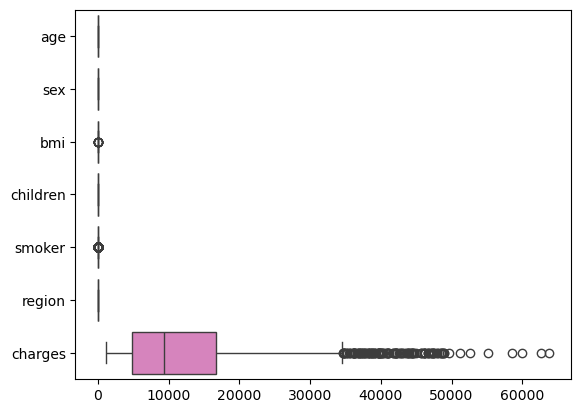

In [11]:
sns.boxplot(data=data,orient='h')
plt.show();

In [12]:
def wisker(col):
    q1,q3 = np.percentile(col,[25,75])
    iqr = q3-q1
    lw = q1-1.5*iqr
    uw = q3+1.5*iqr
    return lw,uw
    

In [15]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [16]:
for i in [['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']]:
    lw,uw = wisker(data[i])
    data[i] = np.where (data[i]<lw,lw,data[i])
    data[i] = np.where (data[i]>lw,uw,data[i])

In [19]:
X = data.drop(['charges'],axis=1)
y = data['charges']


In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [21]:
from sklearn.pipeline import Pipeline

In [ ]:
XGBRegressor()

In [ ]:
model_params = {
    'XGBR' :{ XGBRegressor(),
    'params':{'n_estimators':[100,200],
              'max_depth':[10,20,None]}}}



       
       'RF': RandomForestRegressor()
       

In [22]:
models = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}  # No hyperparameters for LinearRegression by default
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(),
        "params": {
            'max_depth': [3, 5, 10],
            'min_samples_split': [2, 5, 10]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(),
        "params": {
            'n_estimators': [50, 100],
            'max_depth': [3, 5, 10]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(objective='reg:squarederror'),
        "params": {
            'n_estimators': [50, 100],
            'max_depth': [3, 5, 10],
            'learning_rate': [0.01, 0.1]
        }
    }
}


In [23]:
from sklearn.metrics import mean_squared_error,r2_score

In [26]:
results = []

for name, m in models.items():
    print(f"\nRunning GridSearchCV for {name}")
    grid = GridSearchCV(m["model"], m["params"], cv=5, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'MSE': mse,
        'R2 Score': r2
    })

# Convert results to DataFrame
results_data = pd.DataFrame(results)
print(results_data)


Running GridSearchCV for Linear Regression

Running GridSearchCV for Decision Tree

Running GridSearchCV for Random Forest

Running GridSearchCV for XGBoost
               Model                                        Best Params  MSE  R2 Score
0  Linear Regression                                                 {}  0.0       1.0
1      Decision Tree           {'max_depth': 3, 'min_samples_split': 2}  0.0       1.0
2      Random Forest               {'max_depth': 3, 'n_estimators': 50}  0.0       1.0
3            XGBoost  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  0.0       1.0


In [29]:
from sklearn.impute import SimpleImputer

In [30]:
preprocessor = Pipeline([
    ('imputer',SimpleImputer(strategy='mean')),
    ('scaler',StandardScaler())
])

In [34]:
models = {'DT':(DecisionTreeRegressor(),
                {
                 'model__max_depth':[3,5,None]   
                }),
         'RF':(RandomForestRegressor(),
                {
                 'model__max_depth':[5,None],
                 'model__n_estimators':[100,200]
                }),
          'XGB':(XGBRegressor(),
                {
                 'model__max_depth':[3,5],
                 'model__n_estimators':[100]
                }),

         }

In [35]:
from sklearn.model_selection import GridSearchCV
best_model = None
best_score = 0

for name,(model,params) in models.items():
    pipe = Pipeline([
        ('prep',preprocessor),
        ('model',model)
    ])
    
    grid = GridSearchCV(pipe,param_grid=params,cv=5,scoring='r2')
    grid.fit(X_train,y_train)
    if grid.best_score_>best_score:
        best_score = grid.best_score_
        best_model = grid.best_estimator_

In [36]:
best_score

1.0

In [37]:
best_model

Pipeline(steps=[('prep',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', StandardScaler())])),
                ('model', DecisionTreeRegressor(max_depth=3))])

In [38]:
models = {
    'LR': (
        LinearRegression(),
        {}  # No hyperparameters to tune
    ),
    'DT': (
        DecisionTreeRegressor(),
        {
            'model__max_depth': [3, 5, None]
        }
    ),
    'RF': (
        RandomForestRegressor(),
        {
            'model__max_depth': [5, None],
            'model__n_estimators': [100, 200]
        }
    ),
    'XGB': (
        XGBRegressor(objective='reg:squarederror'),
        {
            'model__max_depth': [3, 5],
            'model__n_estimators': [100]
        }
    )
}

In [40]:
best_model = None
best_score = -float('inf')  # initialize to negative infinity
best_name = ""

for name, (model, params) in models.items():
    pipe = Pipeline([
        ('prep', preprocessor),  # Your data preprocessing pipeline
        ('model', model)
    ])
    
    grid = GridSearchCV(pipe, param_grid=params, cv=5, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    print(f"{name} Best Score: {grid.best_score_:.4f}")
    
    if grid.best_score_ > best_score:
        best_score = grid.best_score_
        best_model = grid.best_estimator_
        best_name = name

print(f"\nBest Model: {best_name}")
print(f"Best R2 Score: {best_score:.4f}")

LR Best Score: 1.0000
DT Best Score: 1.0000
RF Best Score: 1.0000
XGB Best Score: 1.0000

Best Model: LR
Best R2 Score: 1.0000
